In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
import tensorflow_addons as tfa
import numpy as np

import matplotlib.pyplot as plt

# verify if GPU is available
print(tf.test.is_gpu_available())

# set memory growth to true
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Setting memory growth to True for GPU: ", physical_devices[0])
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# dont display much info of tensorflow
tf.get_logger().setLevel('ERROR')


2024-01-26 14:33:24.803904: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-26 14:33:24.860602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 14:33:24.860640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 14:33:24.863851: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 14:33:24.877457: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-01-26 14:33:28.606486: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-26 14:33:28.675262: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-26 14:33:28.675438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
params = np.load(y_path)
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
feats = np.load(feats_path)
print("feats shape: ", feats.shape)

# use laser power and velocity as labels
params = params[:, :2]
print("y shape: ", params.shape)

y = np.concatenate((params, feats[:, 1:3]), axis=1) # L, H
print("y shape: ", y.shape)

y_max = np.max(y, axis=0)
y = y / y_max

# print max of each column
print("max of each column: ", y_max)

manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
feats shape:  (9587, 8)
y shape:  (9587, 2)
y shape:  (9587, 4)
max of each column:  [2750.   15.  232.  159.]


In [3]:
# shuffle manta and xiris without lossign correspondence y values
indices = np.arange(manta.shape[0])
# seed
np.random.seed(42)
np.random.shuffle(indices)

manta = manta[indices]
xiris = xiris[indices]
y = y[indices]

# split data into train, validation and test
train_split = 0.8
test_split = 0.2

train_split_idx = int(manta.shape[0] * train_split)
test_split_idx = int(manta.shape[0] * test_split)

x_train_manta = manta[:train_split_idx]
x_train_xiris = xiris[:train_split_idx]
y_train = y[:train_split_idx]

x_test_manta = manta[train_split_idx:]
x_test_xiris = xiris[train_split_idx:]
y_test = y[train_split_idx:]

X_train = np.concatenate((x_train_manta, x_train_xiris), axis=0)
y_train = np.concatenate((y_train, y_train), axis=0)

# shapes
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

y_test_all = np.concatenate((y_test, y_test), axis=0)

X_train shape:  (15338, 320, 320)
y_train shape:  (15338, 4)


In [4]:
def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    #x = Dense(128, activation='relu')(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

def add_projection_head(input_shape, encoder, embedding_dim, regression_dim=1):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)
    
    contrastive_outputs = [Dense(embedding_dim, activation='sigmoid', name=f"contrastive_output_{i}", use_bias=False)(features) for i in range(num_tasks)]

    # merge contrastive outputs
    merged_contrastive_outputs = tf.keras.layers.concatenate(contrastive_outputs, axis=1)
    
    x = Dense(128, activation='relu')(merged_contrastive_outputs)
    
    # head regression head with merged contrastive outputs
    regression_outputs = [Dense(regression_dim, activation='linear', name=f"regression_output_{i}", use_bias=False)(x) for i in range(num_tasks)]

    model = Model(inputs=inputs, outputs=contrastive_outputs + regression_outputs)
    return model

2
    def train_step(self, data):
        X, y = data

        # Freeze gradients for contrastive loss
        for layer in self.contrastive_layers:
            layer.trainable = True

        with tf.GradientTape() as tape_contrastive:
            y_pred = self.sup_model(X)
            loss_p = self.supervised_contrastive_loss(y[:, 0], y_pred[0])
            loss_v = self.supervised_contrastive_loss(y[:, 1], y_pred[1])
            loss = loss_p + loss_v

        gradients_contrastive = tape_contrastive.gradient(loss, self.sup_model.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients_contrastive, self.sup_model.trainable_weights))

        # Freeze gradients for next iteration
        for layer in self.sup_model.layers[5:]:
            layer.trainable = False

        with tf.GradientTape() as tape_regression:
            y_pred = self.sup_model(X)
            loss_reg_l = tf.keras.losses.MSE(y[:, 2], y_pred[2])
            loss_reg_h = tf.keras.losses.MSE(y[:, 3], y_pred[3])
            loss_reg = loss_reg_l + loss_reg_h
            loss += loss_reg

        # Unfreeze gradients for regression loss
        for layer in self.sup_model.layers[5:]:
            layer.trainable = True

        gradients_regression = tape_regression.gradient(loss_reg, self.sup_model.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients_regression, self.sup_model.trainable_weights))

        self.loss_tracker.update_state(loss)
        self.loss_l_tracker.update_state(loss_reg_l)
        self.loss_h_tracker.update_state(loss_reg_h)

        return {"loss": self.loss_tracker.result(), "loss_l": self.loss_l_tracker.result(),
                "loss_h": self.loss_h_tracker.result()}
    
    def test_step(self, data):
        X, y = data

        y_pred = self.sup_model(X)
        loss_p = self.supervised_contrastive_loss(y[:, 0], y_pred[0])
        loss_v = self.supervised_contrastive_loss(y[:, 1], y_pred[1])
        loss_reg_l = tf.keras.losses.MSE(y[:, 2], y_pred[2])
        loss_reg_h = tf.keras.losses.MSE(y[:, 3], y_pred[3])
        loss = loss_p + loss_v + loss_reg_l + loss_reg_h

        self.loss_tracker.update_state(loss)
        self.loss_l_tracker.update_state(loss_reg_l)
        self.loss_h_tracker.update_state(loss_reg_h)

        return {"loss": self.loss_tracker.result(), "loss_l": self.loss_l_tracker.result(),
                "loss_h": self.loss_h_tracker.result()}

    def supervised_contrastive_loss(self, labels, feature_vectors):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

    @property
    def metrics(self):
        return [self.loss_tracker]

input_shape = (320, 320, 1)
embedding_dim = 128
regression_dim = 1
num_tasks = 2  # Number of contrastive tasks

encoder = create_encoder(input_shape)
encoder_with_projection_head = add_projection_head(input_shape, encoder, embedding_dim, regression_dim)
encoder_with_projection_head.summary()
    
model = SupConModel(encoder_with_projection_head, temperature=0.05)
for i, layer in enumerate(model.sup_model.layers):
    print(i, layer.name)
    
print(model.sup_model.layers[0:5])
print(model.sup_model.layers[5:])


learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))

batch_size = 64
epochs = 50

history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)




2024-01-26 14:33:48.427800: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-26 14:33:48.428017: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-26 14:33:48.428108: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 92416)                23296     ['input_2[0][0]']             
                                                                                                  
 contrastive_output_0 (Dens  (None, 128)                  1182924   ['model[0][0]']               
 e)                                                       8                                       
                                                                                                  
 contrastive_output_1 (Dens  (None, 128)                  1182924   ['model[0][0]']         

2024-01-26 14:34:05.032814: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-26 14:34:05.282369: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-26 14:34:05.916853: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-26 14:34:08.393459: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f79b81ccb00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-26 14:34:08.393501: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-26 14:34:08.405117: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706279648.658655  138037 device_compiler.h:186] 

192/192 [==============================] - 30s 111ms/step - loss: 8.2641 - loss_l: 0.0584 - loss_h: 0.0452 - val_loss: 8.3515 - val_loss_l: 0.0548 - val_loss_h: 0.0176
Epoch 2/50
192/192 [==============================] - 14s 74ms/step - loss: 8.1708 - loss_l: 0.0542 - loss_h: 0.0159 - val_loss: 8.3326 - val_loss_l: 0.0538 - val_loss_h: 0.0144
Epoch 3/50
192/192 [==============================] - 14s 75ms/step - loss: 8.0861 - loss_l: 0.0536 - loss_h: 0.0138 - val_loss: 8.2362 - val_loss_l: 0.0537 - val_loss_h: 0.0133
Epoch 4/50
192/192 [==============================] - 14s 74ms/step - loss: 7.9297 - loss_l: 0.0536 - loss_h: 0.0130 - val_loss: 8.0346 - val_loss_l: 0.0535 - val_loss_h: 0.0127
Epoch 5/50
192/192 [==============================] - 14s 73ms/step - loss: 7.7452 - loss_l: 0.0535 - loss_h: 0.0126 - val_loss: 7.8466 - val_loss_l: 0.0534 - val_loss_h: 0.0124
Epoch 6/50
192/192 [==============================] - 14s 71ms/step - loss: 7.5654 - loss_l: 0.0534 - loss_h: 0.0123 - v

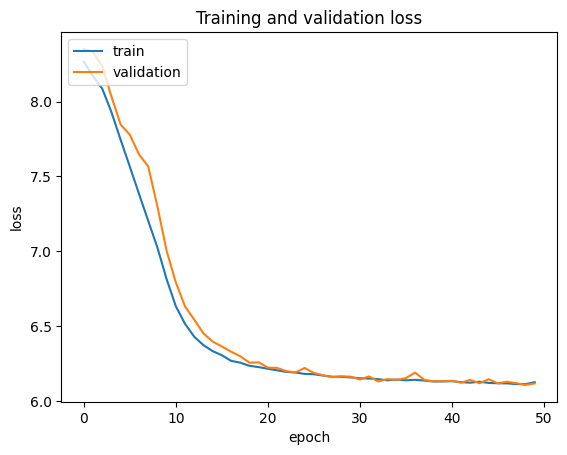

In [5]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [6]:
# Get test datasets
X_test = np.concatenate((x_test_manta, x_test_xiris), axis=0)
#x_test_manta
y_test_manta = y_test
y_test = np.concatenate((y_test, y_test), axis=0)



In [7]:
# eval regression model
from sklearn.metrics import r2_score

_, _, y_pred_l, y_pred_h = model.sup_model.predict(X_test)
r2_l = r2_score(y_test[:,2], y_pred_l)
r2_h = r2_score(y_test[:,3], y_pred_h)
print("r2 score: ", r2_l, r2_h)


120/120 [==============================] - 2s 12ms/step
r2 score:  0.014273147204082348 0.02716515757720006


In [8]:
_, _, y_pred_l_new, y_pred_h_new = model.sup_model.predict(x_test_manta)
r2_l_new = r2_score(y_test_manta[:,2], y_pred_l_new)
r2_h_new = r2_score(y_test_manta[:,3], y_pred_h_new)

print("r2 score: ", r2_l_new, r2_h_new)

60/60 [==============================] - 1s 13ms/step
r2 score:  0.016896925473699698 0.03580456531427623


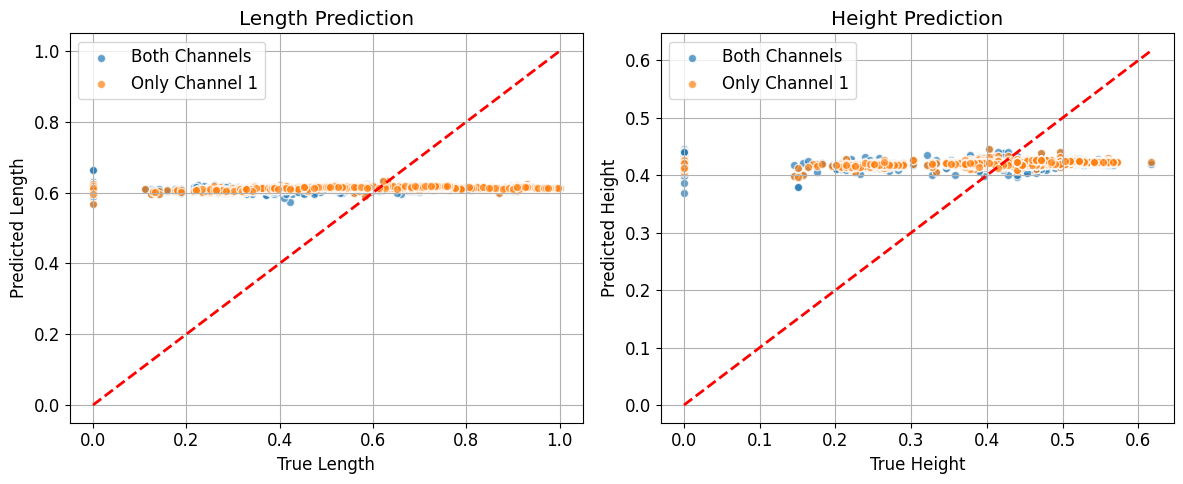

In [9]:
# Increase overall text size
plt.rcParams.update({'font.size': 12})

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the first scatter plot (length prediction)
axs[0].scatter(y_test[:, 2], y_pred_l, alpha=0.7, edgecolors='w', label='Both Channels')
axs[0].scatter(y_test_manta[:, 2], y_pred_l_new, alpha=0.7, edgecolors='w', label='Only Channel 1')
axs[0].plot([min(y_test[:, 2]), max(y_test[:, 2])], [min(y_test[:, 2]), max(y_test[:, 2])], '--', color='red', linewidth=2)
axs[0].set_title("Length Prediction")
axs[0].set_xlabel("True Length")
axs[0].set_ylabel("Predicted Length")
axs[0].legend()
axs[0].grid(True)

# Plotting the second scatter plot (height prediction)
axs[1].scatter(y_test[:, 3], y_pred_h, alpha=0.7, edgecolors='w', label='Both Channels')
axs[1].scatter(y_test_manta[:, 3], y_pred_h_new, alpha=0.7, edgecolors='w', label='Only Channel 1')
axs[1].plot([min(y_test[:, 3]), max(y_test[:, 3])], [min(y_test[:, 3]), max(y_test[:, 3])], '--', color='red', linewidth=2)
axs[1].set_title("Height Prediction")
axs[1].set_xlabel("True Height")
axs[1].set_ylabel("Predicted Height")
axs[1].legend()
axs[1].grid(True)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

Layer name: dense


120/120 [==============================] - 1s 9ms/step


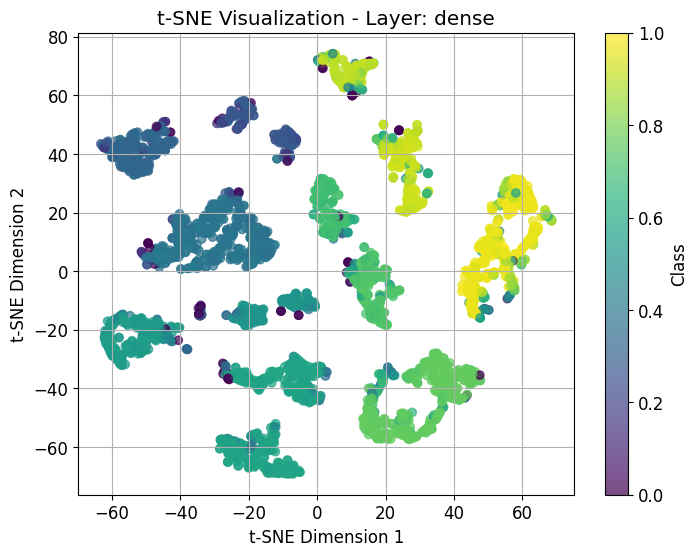

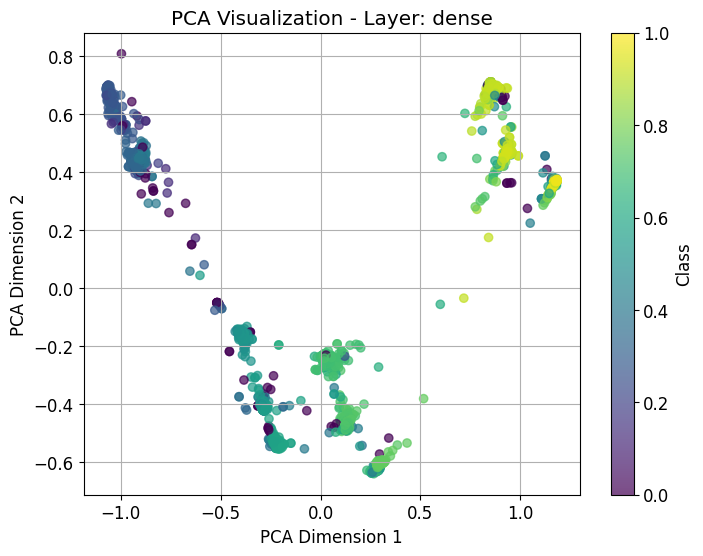

Layer name: dense
60/60 [==============================] - 1s 9ms/step


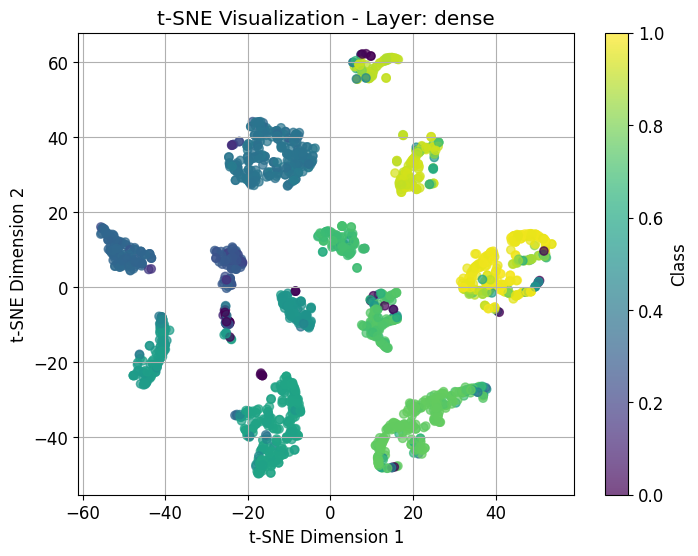

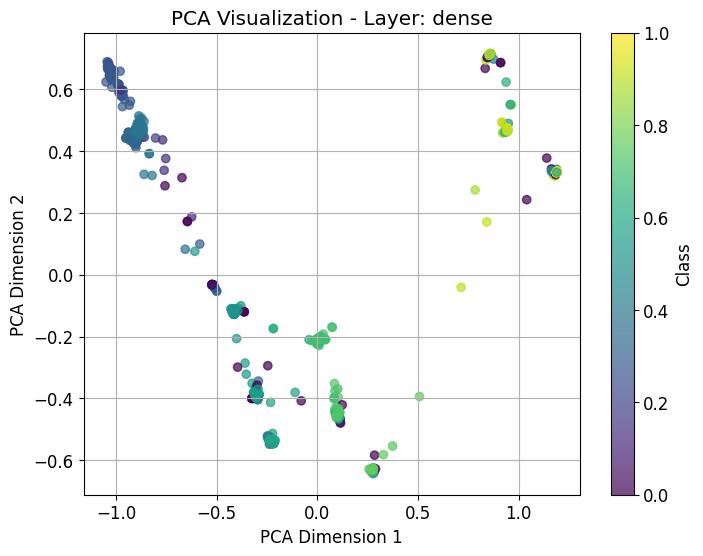

(array([[ 20.171215 ,  34.23694  ],
        [ -5.0706706, -10.401028 ],
        [ 33.999054 ,   3.3397427],
        ...,
        [ 16.758091 , -37.067707 ],
        [-13.094209 ,  29.601698 ],
        [ 36.809795 ,   2.0386386]], dtype=float32),
 array([[ 0.9425021 ,  0.46666306],
        [-0.41339815, -0.12734671],
        [ 1.188874  ,  0.3321193 ],
        ...,
        [ 0.27154526, -0.63086635],
        [-0.87287945,  0.5072191 ],
        [ 1.1888437 ,  0.33201048]], dtype=float32))

In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

N_LAYER = -3

def eval_tsne_pca(model, n_layer, x_test, y_test, plot=True):
    
    # Get intermediate layer output and print the name
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[n_layer].output)
    layer_name = model.layers[n_layer].name
    print("Layer name:", layer_name)
    
    intermediate_activations = intermediate_layer_model.predict(x_test)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(intermediate_activations)

    # Visualize t-SNE results
    if plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test[:, 2], cmap='viridis', alpha=0.7)
        plt.title(f't-SNE Visualization - Layer: {layer_name}')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.colorbar(label='Class')
        plt.grid(True)
        plt.show()

    # Apply PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(intermediate_activations)

    # Visualize PCA results
    if plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(pca_results[:, 0], pca_results[:, 1], c=y_test[:, 2], cmap='viridis', alpha=0.7)
        plt.title(f'PCA Visualization - Layer: {layer_name}')
        plt.xlabel('PCA Dimension 1')
        plt.ylabel('PCA Dimension 2')
        plt.colorbar(label='Class')
        plt.grid(True)
        plt.show()

    return tsne_results, pca_results

eval_tsne_pca(model.sup_model, n_layer=N_LAYER, x_test=X_test, y_test=y_test, plot=True)

eval_tsne_pca(model.sup_model, n_layer=N_LAYER, x_test=x_test_manta, y_test=y_test_manta, plot=True)

In [11]:
""" from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

N_LAYER = -3

def eval_tsne_pca(model, n_layer, x_test, y_test, plot=True):
    
    # Get intermediate layer output and print the name
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[n_layer].output)
    layer_name = model.layers[n_layer].name
    print("Layer name:", layer_name)
    
    intermediate_activations = intermediate_layer_model.predict(x_test)

    # Apply t-SNE or PCA
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(intermediate_activations)

    # Visualize t-SNE results
    if plot:
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test[:, 0], cmap='jet')
        plt.colorbar()
        plt.show()

    # apply PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(intermediate_activations)

    # Visualize PCA results
    if plot:
        plt.scatter(pca_results[:, 0], pca_results[:, 1], c=y_test[:, 0], cmap='jet')
        plt.colorbar()
        plt.show()

    return tsne_results, pca_results

eval_tsne_pca(model_3, n_layer=N_LAYER, x_test=X_test, y_test=y_test, plot=True)

eval_tsne_pca(model_3, n_layer=N_LAYER, x_test=X_test_new, y_test=y_test_new, plot=True)

# eval for X_test_new
 """

' from sklearn.manifold import TSNE\nfrom sklearn.decomposition import PCA\n\nN_LAYER = -3\n\ndef eval_tsne_pca(model, n_layer, x_test, y_test, plot=True):\n    \n    # Get intermediate layer output and print the name\n    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[n_layer].output)\n    layer_name = model.layers[n_layer].name\n    print("Layer name:", layer_name)\n    \n    intermediate_activations = intermediate_layer_model.predict(x_test)\n\n    # Apply t-SNE or PCA\n    tsne = TSNE(n_components=2, random_state=42)\n    tsne_results = tsne.fit_transform(intermediate_activations)\n\n    # Visualize t-SNE results\n    if plot:\n        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test[:, 0], cmap=\'jet\')\n        plt.colorbar()\n        plt.show()\n\n    # apply PCA\n    pca = PCA(n_components=2)\n    pca_results = pca.fit_transform(intermediate_activations)\n\n    # Visualize PCA results\n    if plot:\n        plt.scatter(pca_results